# Importancia de cada columna del set original

## Constantes globales 

In [7]:
TARGET = 'precio'

## Imports 

#### Import pandas, numpy and & plots 

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#### Import sklearn

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestRegressor # precio es variable continua
from sklearn.model_selection import train_test_split

#### Import common 

In [1]:
import common.common_machine_learning as common

## Carga optimizada del set de datos 

In [4]:
train = common.cargar_set_optimizado('sets_de_datos/train.csv')

## Funciones y metodos de scoring

Mediremos cuanto depende el target : precio, de cada columna del set original: train.csv  

Funcion de scoring: 

- f_classif (ANOVA F-value)
- chi2 (X^2), 
- mutual information score.

Todas las anteriores son 'Univariate Feature Selectors'.
Puede utilizarze SelectKBest para seleccionar las K mejores features, a partir de alguna de las funciones anteriores.

Otros metodos de scoring.

- L1 regularization (Lasso Regression)
- Random Forest


In [14]:
feature_cols = train.columns.drop(TARGET)
train_X = train.drop([TARGET], axis=1)
train_y = train[TARGET]
train_X_train, train_X_test, train_y_train, train_y_test = train_test_split(
                                                                train_X, 
                                                                train_y, 
                                                                test_size=0.25, 
                                                                random_state=1)

Solo vamos a usar train_X_train

### f_classif

In [6]:
feature_cols = train.columns.drop('precio')
#train, valid, _ = get_data_splits(baseline_data)
train_X_train, train_X_test, train_y_train, train_y_test = train_test_split(train, )
selector = SelectKBest(f_classif, k=3)

X_new = selector.fit_transform(train[feature_cols], train['outcome'])
X_new

NameError: name 'get_data_splits' is not defined

In [51]:
baseline_data.shape

(375862, 9)

In [52]:
X_new.shape

(300690, 3)

In [53]:
feature_cols

Index(['goal', 'hour', 'day', 'month', 'year', 'category', 'currency',
       'country'],
      dtype='object')

In [54]:
selector.scores_

array([ 176.44548895,   27.78178553,   78.43201755,   35.47464461,
       2161.42005091,  175.92221881, 1359.91885484, 1293.74304514])

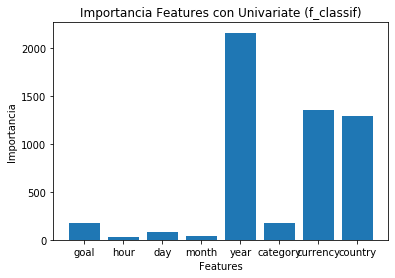

In [55]:
plt.bar(feature_cols, selector.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (f_classif)')
plt.show()

In [56]:
selected_features = pd.DataFrame(selector.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country
0,0.0,0.0,0.0,0.0,2015.0,0.0,5.0,9.0
1,0.0,0.0,0.0,0.0,2017.0,0.0,13.0,22.0
2,0.0,0.0,0.0,0.0,2013.0,0.0,13.0,22.0
3,0.0,0.0,0.0,0.0,2012.0,0.0,13.0,22.0
4,0.0,0.0,0.0,0.0,2015.0,0.0,13.0,22.0


In [57]:
selected_columns = selected_features.columns[selected_features.var() != 0]

In [58]:
selected_columns

Index(['year', 'currency', 'country'], dtype='object')

In [59]:
valid[selected_columns].head()

,year,currency,country
302896,2015,13,22
302897,2013,13,22
302898,2014,5,9
302899,2014,13,22
302900,2014,5,9


### chi2

In [60]:
selector_chi2 = SelectKBest(chi2, k=3)

X_new = selector_chi2.fit_transform(train[feature_cols], train['outcome'])

In [61]:
selector_chi2.scores_

array([4.99855268e+09, 1.26053903e+02, 3.98590901e+02, 6.03993972e+01,
       3.94426051e+00, 4.42256496e+03, 1.91106807e+03, 2.68209037e+03])

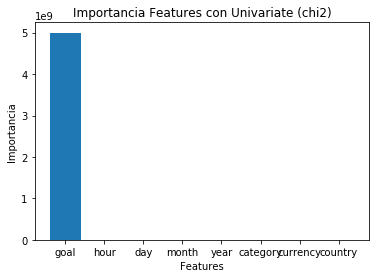

In [62]:
plt.bar(feature_cols, selector_chi2.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (chi2)')
plt.show()

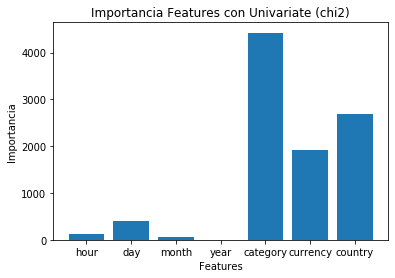

In [63]:
plt.bar(feature_cols[1:], selector_chi2.scores_[1:])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (chi2)')
plt.show()

### mutual_info_classif

In [64]:
selector_mutual = SelectKBest(mutual_info_classif, k=3)

X_new = selector_mutual.fit_transform(train[feature_cols], train['outcome'])

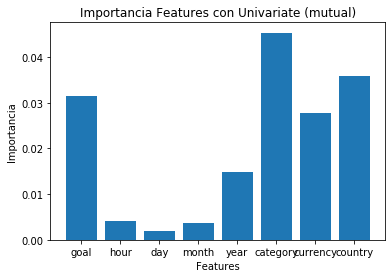

In [65]:
plt.bar(feature_cols, selector_mutual.scores_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Univariate (mutual)')
plt.show()

## L1 regularization (Lasso Regression)

Penalización al aumentar la complejidad del modelo

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

train, valid, _ = get_data_splits(baseline_data)

X, y = train[train.columns.drop("outcome")], train['outcome']

# Set the regularization parameter C=1
logistic = LogisticRegression(C=1, penalty="l1", random_state=7).fit(X, y)

/home/soporte/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [67]:
logistic.coef_

array([[-1.60948774e-05,  3.52696292e-03, -4.01805702e-03,
        -5.35315567e-03, -1.38150607e-04,  1.49581585e-03,
         1.91222965e-02,  9.19151006e-03]])

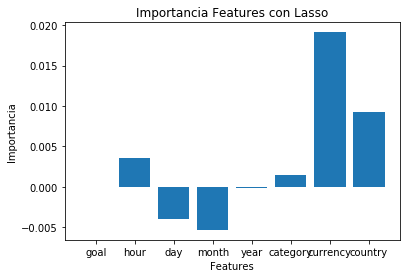

In [68]:
plt.bar(feature_cols, logistic.coef_[0])
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con Lasso')
plt.show()

In [69]:
model = SelectFromModel(logistic, prefit=True, max_features=3)

X_new = model.transform(X)

In [70]:
selected_features = pd.DataFrame(model.inverse_transform(X_new), 
                                 index=train.index, 
                                 columns=feature_cols)
selected_features.head()

,goal,hour,day,month,year,category,currency,country
0,0.0,0.0,0.0,8.0,0.0,0.0,5.0,9.0
1,0.0,0.0,0.0,9.0,0.0,0.0,13.0,22.0
2,0.0,0.0,0.0,1.0,0.0,0.0,13.0,22.0
3,0.0,0.0,0.0,3.0,0.0,0.0,13.0,22.0
4,0.0,0.0,0.0,7.0,0.0,0.0,13.0,22.0


## Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error

X, y = train[train.columns.drop("outcome")], train['outcome']
val_X, val_y = valid[valid.columns.drop("outcome")], valid['outcome']

forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X, y)
preds = forest_model.predict(val_X)
print(mean_absolute_error(val_y, preds))

/home/soporte/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.33802479646676953


In [72]:
forest_model.feature_importances_

array([0.22753218, 0.14630286, 0.19871761, 0.12663167, 0.05700985,
       0.21927226, 0.01028908, 0.01424449])

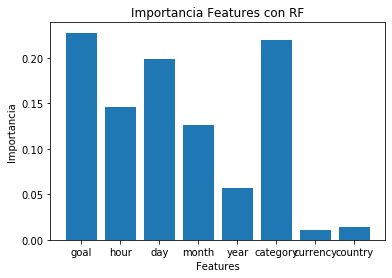

In [73]:
plt.bar(feature_cols, forest_model.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importancia')
plt.title('Importancia Features con RF')
plt.show()

In [74]:
model = SelectFromModel(forest_model, prefit=True, max_features=3)

X_new = model.transform(X)

In [75]:
X_new

array([[1.00e+03, 1.10e+01, 1.08e+02],
       [3.00e+04, 2.00e+00, 9.30e+01],
       [4.50e+04, 1.20e+01, 9.30e+01],
       ...,
       [2.50e+03, 3.00e+00, 1.04e+02],
       [2.60e+03, 2.30e+01, 5.80e+01],
       [2.00e+04, 4.00e+00, 5.20e+01]])